In [1]:
import ROOT as r
import uproot
import hist
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np
import array as arr
from milliqanProcessor import *
from milliqanScheduler import *
from milliqanCuts import *
from milliqanPlotter import *
import os
from functools import partial

%load_ext autoreload
%autoreload 2

Welcome to JupyROOT 6.28/04


In [2]:
def getMaxPulseTime(events):
    t_0 = events.time_module_calibrated[(events.eventCuts) & (events.layer0) & (events.straightPulses)]
    t_1 = events.time_module_calibrated[(events.eventCuts) & (events.layer1) & (events.straightPulses)]
    t_2 = events.time_module_calibrated[(events.eventCuts) & (events.layer2) & (events.straightPulses)]
    t_3 = events.time_module_calibrated[(events.eventCuts) & (events.layer3) & (events.straightPulses)]

    #example of getting max value mask
    events['max_height'] = events.height == ak.max(events.height, axis=1, keepdims=True)

    passingHeights0 = events.height[(events.eventCuts) & (events.layer0) & (events.straightPulses)]
    passingHeights1 = events.height[(events.eventCuts) & (events.layer1) & (events.straightPulses)]
    passingHeights2 = events.height[(events.eventCuts) & (events.layer2) & (events.straightPulses)]
    passingHeights3 = events.height[(events.eventCuts) & (events.layer3) & (events.straightPulses)]

    #print(len(ak.drop_none(ak.flatten(ak.max(passingHeights0, axis=1, keepdims=True)))), len(ak.drop_none(ak.flatten(ak.max(passingHeights1, axis=1, keepdims=True)))), len(ak.drop_none(ak.flatten(ak.max(passingHeights2, axis=1, keepdims=True)))), len(ak.drop_none(ak.flatten(ak.max(passingHeights3, axis=1, keepdims=True)))))

    max_pulse0 = ak.pad_none(passingHeights0, 1, axis=1) == ak.max(passingHeights0, axis=1, keepdims=True, initial=0)
    max_pulse1 = ak.pad_none(passingHeights1, 1, axis=1) == ak.max(passingHeights1, axis=1, keepdims=True, initial=0)
    max_pulse2 = ak.pad_none(passingHeights2, 1, axis=1) == ak.max(passingHeights2, axis=1, keepdims=True, initial=0)
    max_pulse3 = ak.pad_none(passingHeights3, 1, axis=1) == ak.max(passingHeights3, axis=1, keepdims=True, initial=0)

    #print(ak.pad_none(passingHeights0, 1, axis=1))
    #print(ak.max(passingHeights0, axis=1, keepdims=True, initial=0))

    #print(ak.drop_none(max_pulse0, axis=1))

    t_0 = t_0[ak.drop_none(max_pulse0, axis=1)]
    t_1 = t_1[ak.drop_none(max_pulse1, axis=1)]
    t_2 = t_2[ak.drop_none(max_pulse2, axis=1)]
    t_3 = t_3[ak.drop_none(max_pulse3, axis=1)]

    return t_0, t_1, t_2, t_3

initialize
instance of milliqanPlotter
----------------------------
MilliQan Scheduler:
	0. layerCut
	1. fourLayerCut
	2. straightLineCut
	3. eventCuts
	4. <bound method milliqanPlotter.__name__ of <milliqanPlotter.milliqanPlotter object at 0x2a8c9de10>>
----------------------------
Creating cuts
Creating cuts
Creating cuts
Creating cuts
Calling plot method <bound method milliqanPlotter.__name__ of <milliqanPlotter.milliqanPlotter object at 0x2a8c9de10>>
[16.1, 440, 58.5, 1.25e+03, 24, 13.8, ..., 298, 54.9, 1.25e+03, 26.6, 53.9, 581]
Number of events 1000
Number of passing events 150


Warning in <TROOT::Append>: Replacing existing TH1: h_height (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_timeDiff (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_time0 (Potential memory leak).


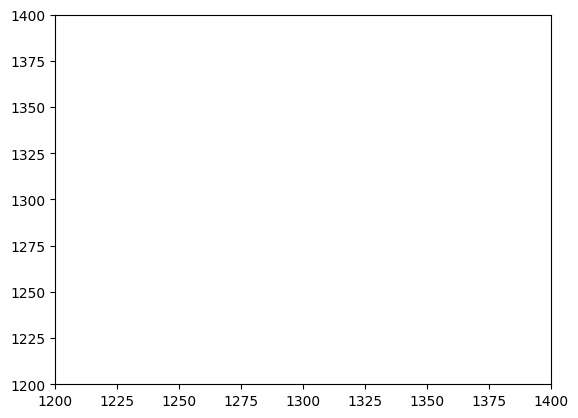

In [9]:
if __name__ == "__main__":

    #define a file list to run over
    filelist = ['~/Desktop/MilliQan/data/MilliQan_Run1185.1_v33.root:t']

    #define the necessary branches to run over
    branches = ['boardsMatched', 'time_module_calibrated', 'height', 'area', 'column', 'row', 'layer']

    #define the milliqan cuts object
    mycuts = milliqanCuts()

    #example of changing cut value
    heightCut200 = mycuts.getLambda(mycuts.heightCut, 'heightCut200', heightCut=200)

    #example of cutting on events
    fourLayerCut = mycuts.getLambda(mycuts.fourLayerCut, 'fourLayerCut', cut=False)

    #example of creating a combined cut
    eventCuts = mycuts.getLambda(mycuts.combineCuts, 'eventCuts', ['fourLayers', 'straightPath'])

    h_height = r.TH1F("h_height", "Height", 140, 0, 1400)
    myplotter = milliqanPlotter(h_height, 'height')

    #defining the cutflow
    cutflow = [mycuts.layerCut, mycuts.fourLayerCut, mycuts.straightLineCut, eventCuts, myplotter]

    #create a schedule of the cuts
    myschedule = milliQanScheduler(cutflow)

    #print out the schedule
    myschedule.printSchedule()
    
    #branchesToMake = [layerCut, fourLayerCut]#, 'straightLineCut', "combineCuts(['fourLayers', 'straightPath']; 'eventCuts')", 'threeAreaSaturatedInLine(50000)', "combineCuts(['eventCuts', 'three_sat']; 'eventCuts')"]

    #create the milliqan processor object
    myiterator = milliqanProcessor(filelist, branches, myschedule, mycuts, myplotter)

    #set custom functions inside iterator if desired
    myiterator.setCustomFunction(getMaxPulseTime)

    #run the milliqan processor
    myiterator.run()


    #note: need a way to make cuts on pulses because 
    #   events = events[pulseCut] 
    # will not work due to the shape of arrays

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


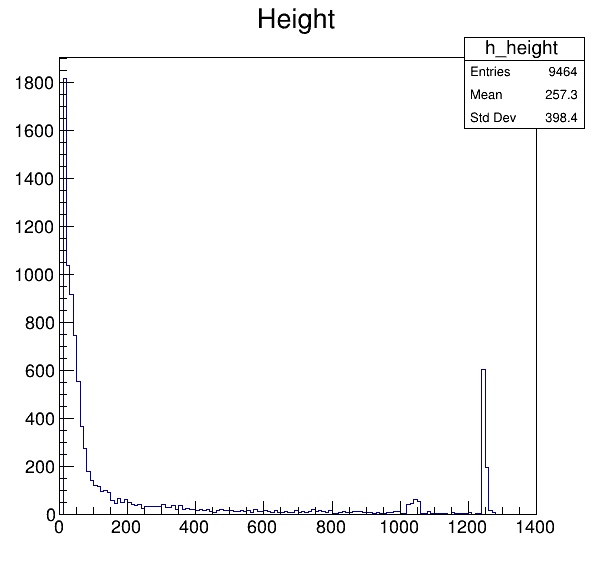

In [10]:
c1 = r.TCanvas("c1", "c1", 600, 600)
c1.cd()
h_height.Draw()
c1.Draw()


In [103]:
isinstance(myplotter, milliqanPlotter)

True

In [25]:
mycuts.layerCut() in dir(milliqanCuts)

AttributeError: 'list' object has no attribute 'layer'

In [109]:
thisAreaCut

<function milliqanCuts.getLambda.<locals>.<lambda>(x)>

In [120]:
import types
types.LambdaType

function

In [123]:
thisAreaCut.__code__.co_name

'<lambda>'